# Uncertain predictions
It can be very useful to generate prediction on how certain the model is about a given prediction. In this work, we take two approaches to doing so. The first is by using a Gaussian Process, which directly predicts uncertainty. Unfortunately, this only work on regression tasks. The second is by using ensambles of generic models. The model is fit on a subset of the data and then the disagreement between the predictions provides a notion of uncertainty. This technique is flexible because any prediction system can be ensambled, for both classification and regression tasks.

In [1]:
from ipp_toolkit.predictors.masked_image_predictor import (
    EnsambledMaskedLabeledImagePredictor,
    UncertainMaskedLabeledImagePredictor,
)
from ipp_toolkit.planners.masked_planner import RandomMaskedPlanner
from ipp_toolkit.predictors.uncertain_predictors import GaussianProcessRegression
from ipp_toolkit.data.domain_data import ALL_LABELED_DOMAIN_DATASETS
from ipp_toolkit.visualization.visualization import visualize_prediction
from sklearn.neural_network import MLPClassifier, MLPRegressor


/home/frc-ag-1/anaconda3/envs/ipp-toolkit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Ensambling
Here we use an ensamble of multilayer perceptron regressors or classifiers. This is tested on a variety of datasets.

Running aiira dataset


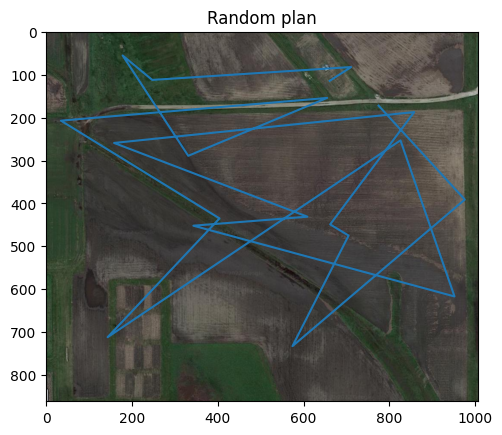

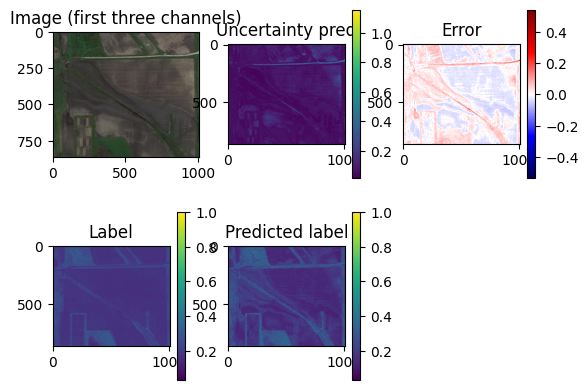

Running safeforest_gmap dataset


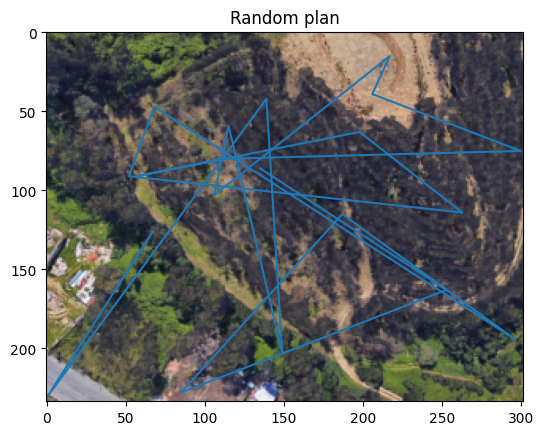

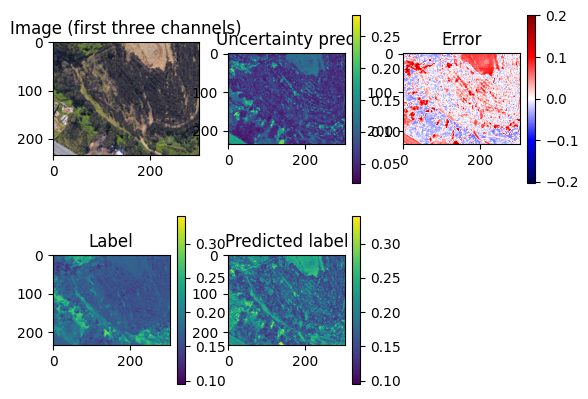

Running safeforest_ortho dataset


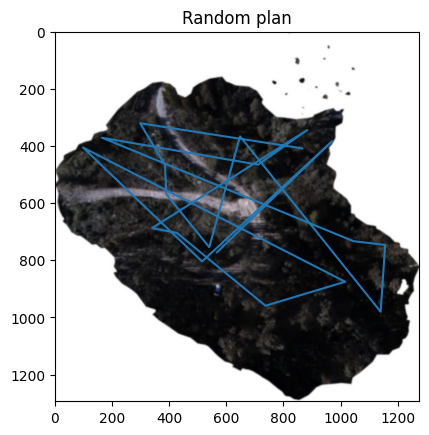

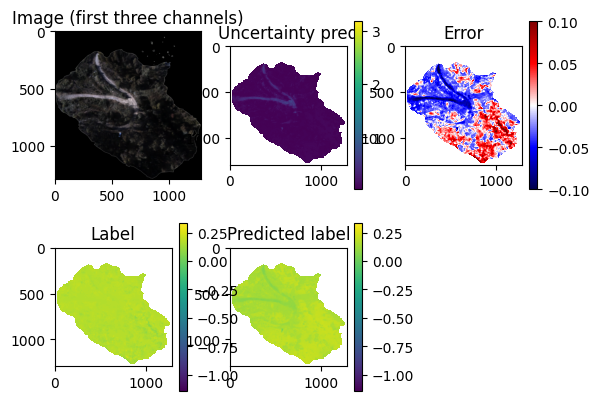

Running yellowcat dataset


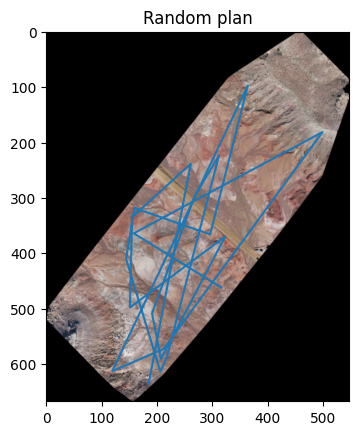

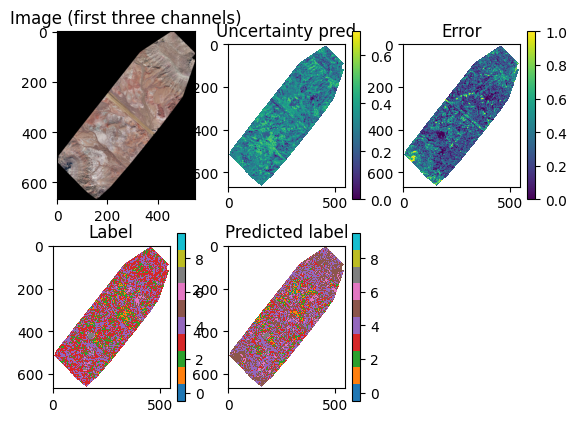

Running chesapeake dataset
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807511_ne_18_060_20181104.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807511_se_18_060_20181104.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807512_nw_18_060_20180815.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807512_sw_18_060_20180815.tif


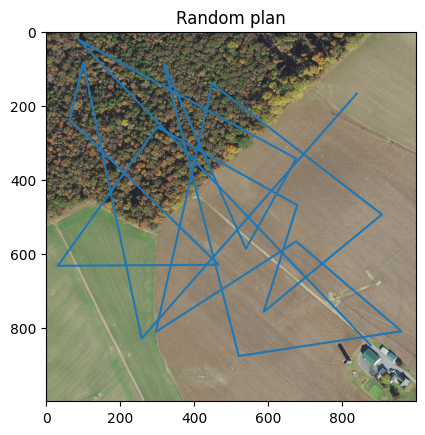

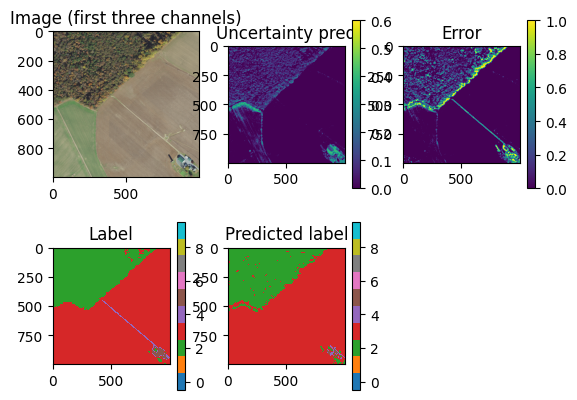

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running coral dataset


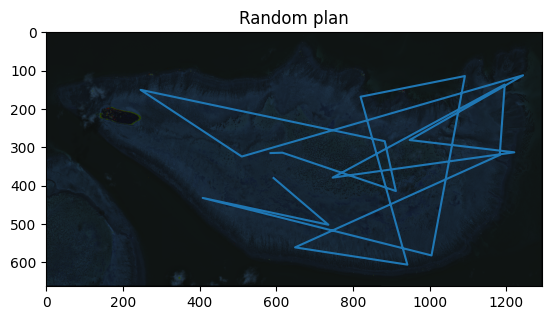

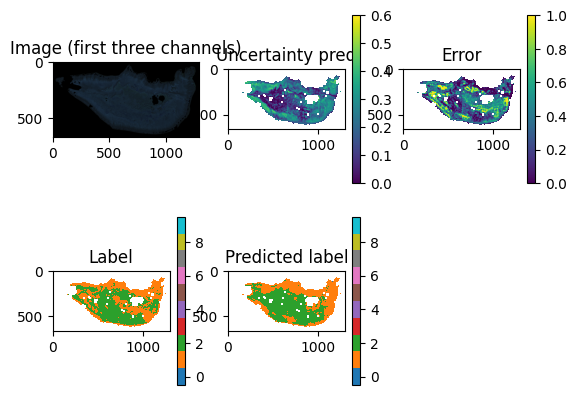

In [2]:
# The number of training samples to observe
N_SAMPLES = 20
for name, dataset_class in ALL_LABELED_DOMAIN_DATASETS.items():
    print(f"Running {name} dataset")
    # Create the data manager
    data = dataset_class()
    # Define a prediction model based on the type of task
    model = (
        MLPClassifier(max_iter=10000)
        if data.is_classification_dataset()
        else MLPRegressor()
    )
    # Create a planner based on the data
    planner = RandomMaskedPlanner(data)
    # Create a predictor to generate predictions on this dataset
    predictor = EnsambledMaskedLabeledImagePredictor(
        data,
        prediction_model=model,
        n_ensamble_models=10,
        classification_task=data.is_classification_dataset(),
    )
    # Get a random plan
    plan = planner.plan(20, vis=True)
    # Sample values from the environment
    values = data.sample_batch(plan)
    # Fit the model
    predictor.update_model(plan, values)
    # Generate predictions for both the label and the label unceratainty
    prediction = predictor.predict_values_and_uncertainty()
    # Visualize these predictions alongside the ground truth
    visualize_prediction(data, prediction, predictor)


### Gaussian Process regression
Here we apply Gaussian Process regression to the datasets which have a regression task.

Running aiira dataset


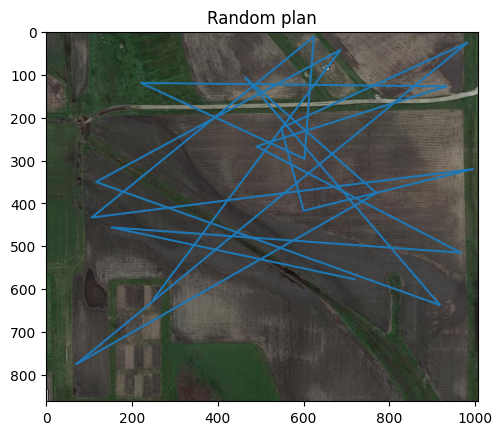

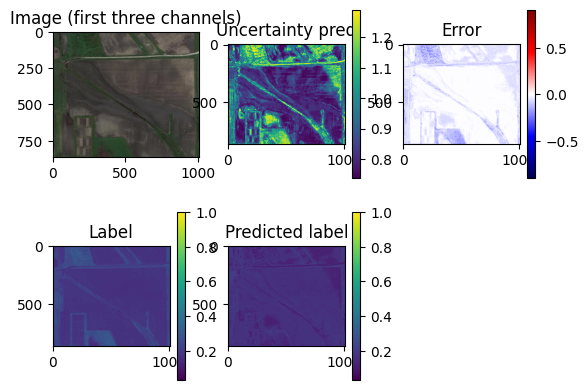

Running safeforest_gmap dataset


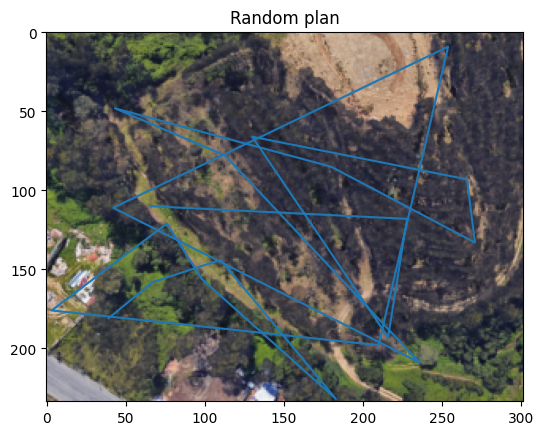

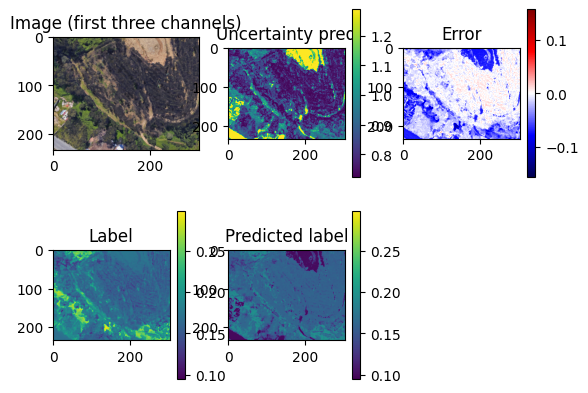

Running safeforest_ortho dataset


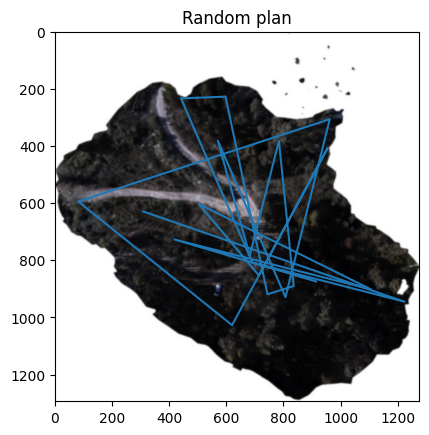

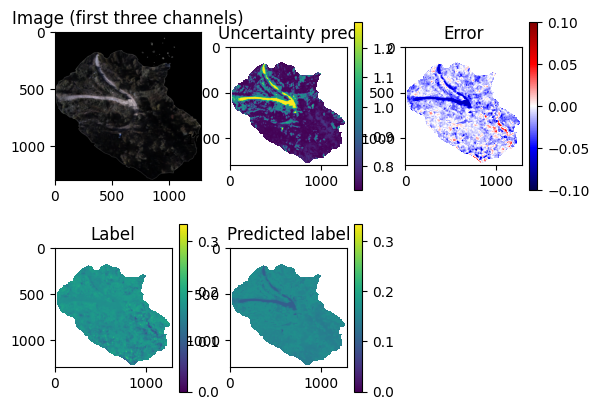

Running yellowcat dataset
The yellowcat dataset is a classification task, which is not supported
Running chesapeake dataset
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807511_ne_18_060_20181104.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807511_se_18_060_20181104.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807512_nw_18_060_20180815.tif
Using downloaded and verified file: /home/frc-ag-1/dev/research/informative-path-planning-toolkit/ipp_toolkit/../data/torchgeo/naip/m_3807512_sw_18_060_20180815.tif
The chesapeake dataset is a classification task, which is not supported
Running coral dataset
The coral dataset is a classification task, which is not supported


In [3]:
# The number of training samples to observe
N_SAMPLES = 20
for name, dataset_class in ALL_LABELED_DOMAIN_DATASETS.items():
    print(f"Running {name} dataset")
    # Create the data manager
    data = dataset_class()
    # The gaussian process regressor does not support classification
    if data.is_classification_dataset():
        print(f"The {name} dataset is a classification task, which is not supported")
        continue
    # Define a gaussian process regression model
    # It will adapt to the number of features at runtim
    gaussian_process = GaussianProcessRegression()
    # Create a planner based on the data
    planner = RandomMaskedPlanner(data)
    # Create a predictor to generate predictions on this dataset
    predictor = UncertainMaskedLabeledImagePredictor(
        data, uncertain_prediction_model=gaussian_process, classification_task=False
    )
    # Get a random plan
    plan = planner.plan(20, vis=True)
    # Sample values from the environment
    values = data.sample_batch(plan)
    # Fit the model
    predictor.update_model(plan, values)
    # Generate predictions for both the label and the label unceratainty
    prediction = predictor.predict_values_and_uncertainty()
    # Visualize these predictions alongside the ground truth
    visualize_prediction(data, prediction, predictor)
